In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
 99% 1.06G/1.06G [00:07<00:00, 250MB/s]
100% 1.06G/1.06G [00:07<00:00, 153MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten,BatchNormalization,Dropout

In [6]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(224,224)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(224,224)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [7]:
# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [8]:
from keras.applications.vgg16 import VGG16
vggmodel = VGG16(weights='imagenet', include_top=True)

553467096/553467096 [==============================] - 2s 0us/step


In [9]:
for layer in vggmodel.layers[:15]:
    layer.trainable = False

In [11]:
from keras.layers import Dense
from keras.models import Model
x = vggmodel.output
x = Flatten(name='flatten_custom')(x)  # Assign a unique name to the Flatten layer
x = Dense(512, activation='relu', name='fc1_custom')(x)  # Unique name for Dense layer
x = Dropout(0.5, name='dropout_custom')(x)  # Unique name for Dropout layer
predictions = Dense(1, activation='sigmoid', name='output_custom')(x)
model_final = Model(vggmodel.input,predictions)

In [13]:
from keras import optimizers
model_final.compile(loss = "binary_crossentropy", optimizer = optimizers.SGD(lr=0.00001), metrics=["accuracy"])
model_final.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [14]:
model_final.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [15]:
history = model_final.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 [==============================] - 149s 215ms/step - loss: 0.5910 - accuracy: 0.7484 - val_loss: 0.3853 - val_accuracy: 0.9158
Epoch 2/10
625/625 [==============================] - 152s 243ms/step - loss: 0.2865 - accuracy: 0.9233 - val_loss: 0.2053 - val_accuracy: 0.9382
Epoch 3/10
625/625 [==============================] - 132s 211ms/step - loss: 0.1559 - accuracy: 0.9555 - val_loss: 0.1649 - val_accuracy: 0.9396
Epoch 4/10
625/625 [==============================] - 152s 242ms/step - loss: 0.1076 - accuracy: 0.9678 - val_loss: 0.1083 - val_accuracy: 0.9616
Epoch 5/10
625/625 [==============================] - 152s 243ms/step - loss: 0.0826 - accuracy: 0.9742 - val_loss: 0.0767 - val_accuracy: 0.9736
Epoch 6/10
625/625 [==============================] - 152s 243ms/step - loss: 0.0660 - accuracy: 0.9791 - val_loss: 0.0752 - val_accuracy: 0.9736
Epoch 7/10
625/625 [==============================] - 152s 242ms/step - loss: 0.0483 - accuracy: 0.9861 - val_loss: 0.0732 -

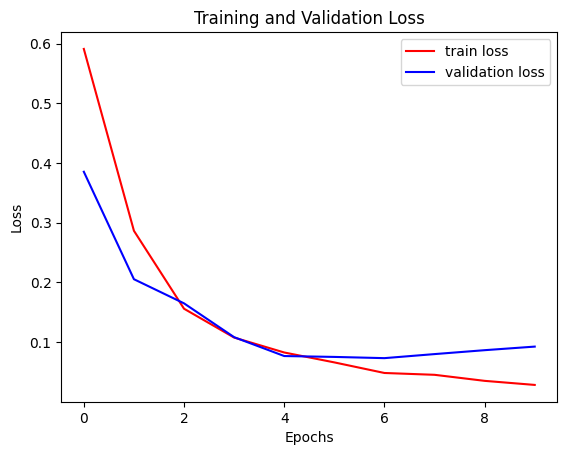

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], color='red', label='train loss')
plt.plot(history.history['val_loss'], color='blue', label='validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()


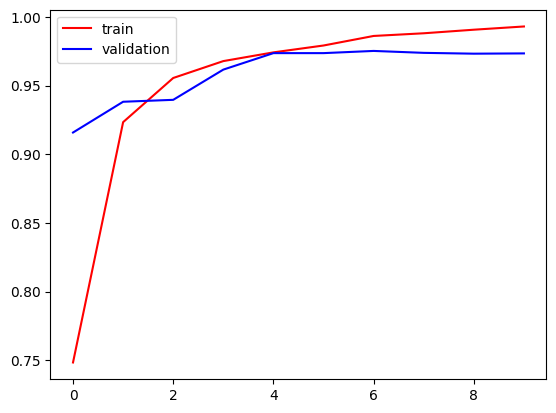

In [18]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()